In [ ]:
!pip install -q tensorflow matplotlib seaborn

In [ ]:
import os
import zipfile
import requests
import shutil
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
import numpy as np

Download and Extract EuroSAT Dataset (RGB)

In [ ]:
url = "https://zenodo.org/record/7711810/files/EuroSAT_RGB.zip?download=1"
zip_path = "EuroSAT_RGB.zip"
extract_path = "EuroSAT_RGB"

if not os.path.exists(extract_path):
    print("Downloading EuroSAT...")
    r = requests.get(url, stream=True)
    with open(zip_path, "wb") as f:
        shutil.copyfileobj(r.raw, f)

    print("Extracting...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(".")
    print("Done.")
else:
    print("Dataset already exists.")

Dataset already exists.


Load Dataset Using image_dataset_from_directory

In [ ]:
data_dir = "EuroSAT_RGB"
img_size = (64, 64)
batch_size = 64
seed = 42

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=seed,
    image_size=img_size,
    batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=seed,
    image_size=img_size,
    batch_size=batch_size
)

class_names = train_ds.class_names
print("Classes:", class_names)

Found 27000 files belonging to 10 classes.
Using 21600 files for training.
Found 27000 files belonging to 10 classes.
Using 5400 files for validation.
Classes: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']


Visualize Sample Images

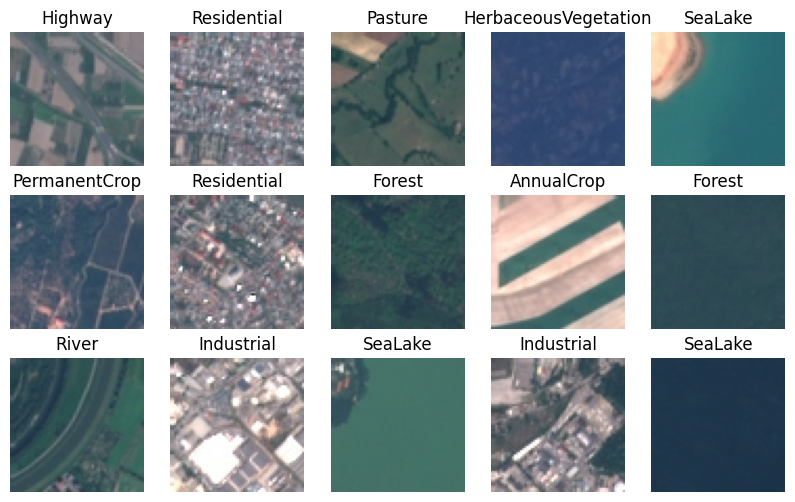

In [ ]:
plt.figure(figsize=(10, 6))
for images, labels in train_ds.take(1):
    for i in range(15):
        ax = plt.subplot(3, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

Check Total Images and Class Distribution

AnnualCrop: 3000 images
Forest: 3000 images
HerbaceousVegetation: 3000 images
Highway: 2500 images
Industrial: 2500 images
Pasture: 2000 images
PermanentCrop: 2500 images
Residential: 3000 images
River: 2500 images
SeaLake: 3000 images


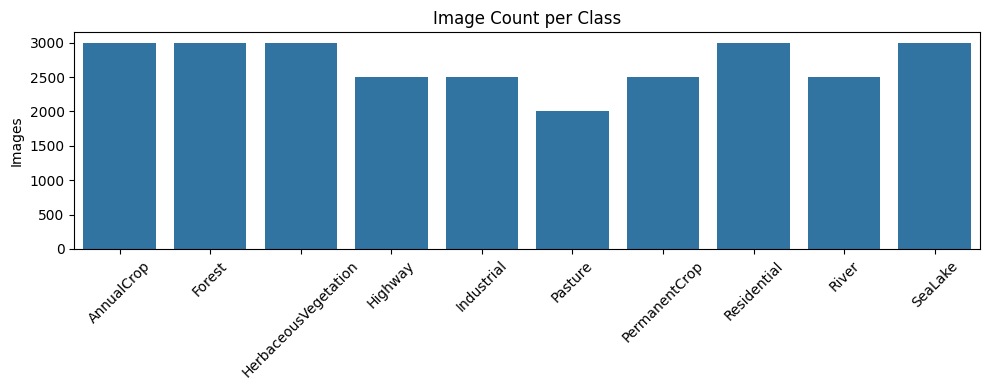

In [ ]:
import os
from collections import Counter

data_dir = "EuroSAT_RGB"
class_counts = {}

for class_name in sorted(os.listdir(data_dir)):
    class_path = os.path.join(data_dir, class_name)
    if os.path.isdir(class_path):
        num_images = len(os.listdir(class_path))
        class_counts[class_name] = num_images

# Print counts
for cls, count in class_counts.items():
    print(f"{cls}: {count} images")

# Plot
plt.figure(figsize=(10, 4))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
plt.xticks(rotation=45)
plt.title("Image Count per Class")
plt.ylabel("Images")
plt.tight_layout()
plt.show()

Check Image Size Consistency

In [ ]:
from PIL import Image

image_shapes = []

for class_folder in os.listdir(data_dir):
    class_path = os.path.join(data_dir, class_folder)
    if os.path.isdir(class_path):
        for img_name in os.listdir(class_path)[:10]:  # sample 10 from each class
            img_path = os.path.join(class_path, img_name)
            img = Image.open(img_path)
            image_shapes.append(img.size)

unique_shapes = set(image_shapes)
print(f"Unique image sizes found: {unique_shapes}")

Unique image sizes found: {(64, 64)}


Visualize a Grid of Images from Each Class

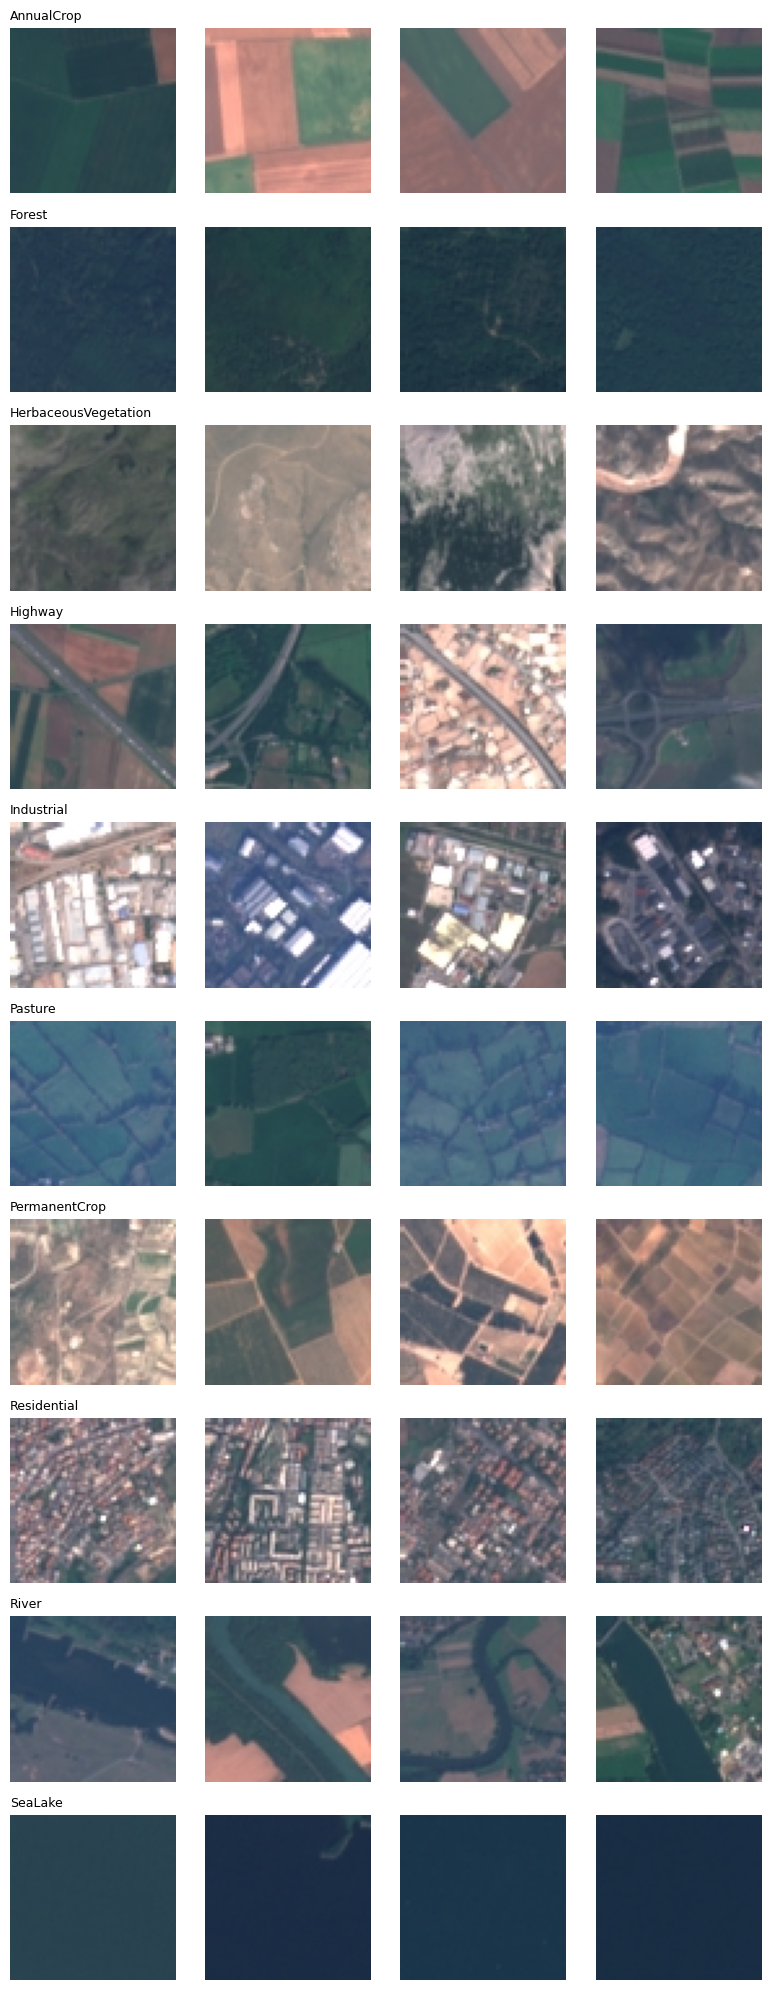

In [ ]:
import random

def plot_images_per_class(root_dir, class_names, samples_per_class=5):
    plt.figure(figsize=(samples_per_class * 2, len(class_names) * 2))

    for row, class_name in enumerate(class_names):
        class_path = os.path.join(root_dir, class_name)
        imgs = os.listdir(class_path)
        samples = random.sample(imgs, samples_per_class)

        for col, img_name in enumerate(samples):
            img_path = os.path.join(class_path, img_name)
            img = Image.open(img_path)

            ax = plt.subplot(len(class_names), samples_per_class, row * samples_per_class + col + 1)
            plt.imshow(img)
            plt.axis("off")
            if col == 0:
                ax.set_title(class_name, fontsize=9, loc='left')

    plt.tight_layout()
    plt.show()

plot_images_per_class(data_dir, class_names, samples_per_class=4)

PCA Visualization of EuroSAT Images

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import load_img, img_to_array

sample_per_class = 300  # sample size per class
img_size = (64, 64)
flat_images = []
flat_labels = []

print("Preparing image features...")

for class_name in class_names:
    class_path = os.path.join(data_dir, class_name)
    img_files = os.listdir(class_path)[:sample_per_class]  # fixed number per class
    for img_file in img_files:
        img_path = os.path.join(class_path, img_file)
        img = load_img(img_path, target_size=img_size)
        img_arr = img_to_array(img) / 255.0  # normalize
        flat_images.append(img_arr.flatten())
        flat_labels.append(class_name)

flat_images = np.array(flat_images)
flat_labels = np.array(flat_labels)

print(f"Total images for PCA: {len(flat_images)}")

Preparing image features...
Total images for PCA: 3000


Running PCA...


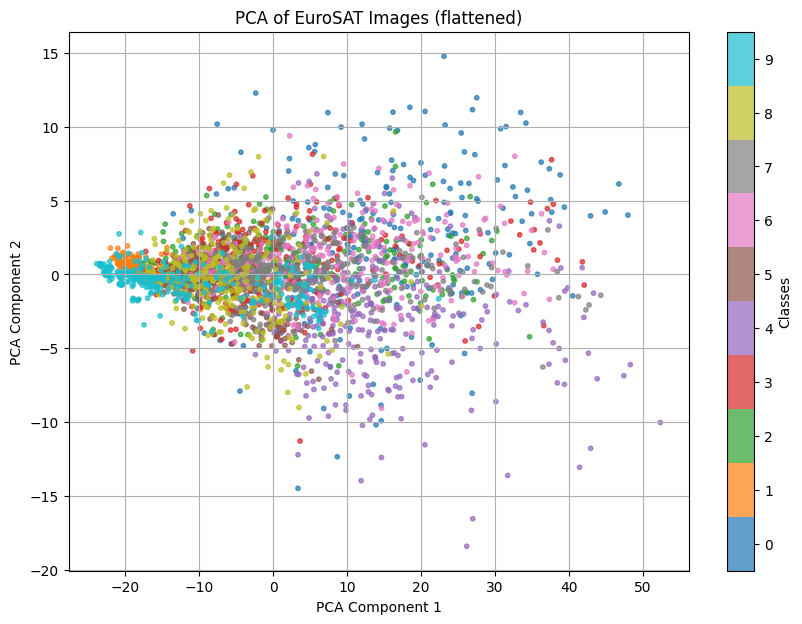

In [ ]:
print("Running PCA...")

pca = PCA(n_components=2)
components = pca.fit_transform(flat_images)

# Encode labels numerically for coloring
label_encoder = LabelEncoder()
numeric_labels = label_encoder.fit_transform(flat_labels)

# Plot
plt.figure(figsize=(10, 7))
scatter = plt.scatter(components[:, 0], components[:, 1], c=numeric_labels, cmap='tab10', s=10, alpha=0.7)
plt.title("PCA of EuroSAT Images (flattened)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(scatter, ticks=range(len(class_names)), label="Classes")
plt.clim(-0.5, len(class_names) - 0.5)
plt.grid(True)
plt.show()

The PCA graph shows a 2D projection of flattened EuroSAT image pixels. Key conclusions:
	•	Class Overlap: Most classes heavily overlap, indicating that raw pixel values alone do not distinctly separate land-use types.
	•	Limited Variance Separation: PCA, being a linear method, captures only basic visual variance (e.g., color or brightness), which is insufficient for fine-grained classification.
	•	Need for Deep Features: The lack of clear clustering reinforces the need for a CNN to extract more complex, hierarchical features.
	•	Slight Clustering: A few classes (e.g., SeaLake or Forest) show minor separation, likely due to distinct visual properties (e.g., water or dense green cover).



Prepare Dataset (Shuffle, Prefetch, Normalize)

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

normalization_layer = layers.Rescaling(1./255)

train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Define Custom CNN Model

In [ ]:
from tensorflow.keras.optimizers import Adam

model = models.Sequential([
    # layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    # layers.MaxPooling2D(2, 2),
    # layers.Conv2D(64, (3, 3), activation='relu'),
    # layers.MaxPooling2D(2, 2),
    # layers.Conv2D(128, (3, 3), activation='relu'),
    # layers.MaxPooling2D(2, 2),
    # layers.Flatten(),
    # layers.Dropout(0.5),
    # layers.Dense(256, activation='relu'),
    # layers.Dense(len(class_names), activation='softmax')

    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(class_names), activation='softmax')
])
learning_rate = 0.0001
optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)              │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,626,442 (6.20 MB)

 Trainable params: 1,626,442 (6.20 MB)

 Non-trainable params: 0 (0.00 B)

Train the Model (with EarlyStopping & Checkpoint)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=4,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=2,
        min_lr=1e-5,
        verbose=1
    ),
    ModelCheckpoint(
        filepath='best_model.keras',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )
]

In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/30
338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step - accuracy: 0.2882 - loss: 1.8925
Epoch 1: val_loss improved from inf to 1.28356, saving model to best_model.keras
338/338 ━━━━━━━━━━━━━━━━━━━━ 144s 377ms/step - accuracy: 0.2885 - loss: 1.8916 - val_accuracy: 0.5122 - val_loss: 1.2836 - learning_rate: 1.0000e-04
Epoch 2/30
338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step - accuracy: 0.5362 - loss: 1.2502
Epoch 2: val_loss improved from 1.28356 to 1.08421, saving model to best_model.keras
338/338 ━━━━━━━━━━━━━━━━━━━━ 126s 373ms/step - accuracy: 0.5363 - loss: 1.2500 - val_accuracy: 0.6243 - val_loss: 1.0842 - learning_rate: 1.0000e-04
Epoch 3/30
338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step - accuracy: 0.6143 - loss: 1.0722
Epoch 3: val_loss improved from 1.08421 to 1.00133, saving model to best_model.keras
338/338 ━━━━━━━━━━━━━━━━━━━━ 123s 365ms/step - accuracy: 0.6143 - loss: 1.0722 - val_accuracy: 0.6398 - val_loss: 1.0013 - learning_rate: 1.0000e-04
Epoch 4/30
338/338 ━━━━━━━━━━━━━━━━━━━

Plot Training/Validation Accuracy and Loss

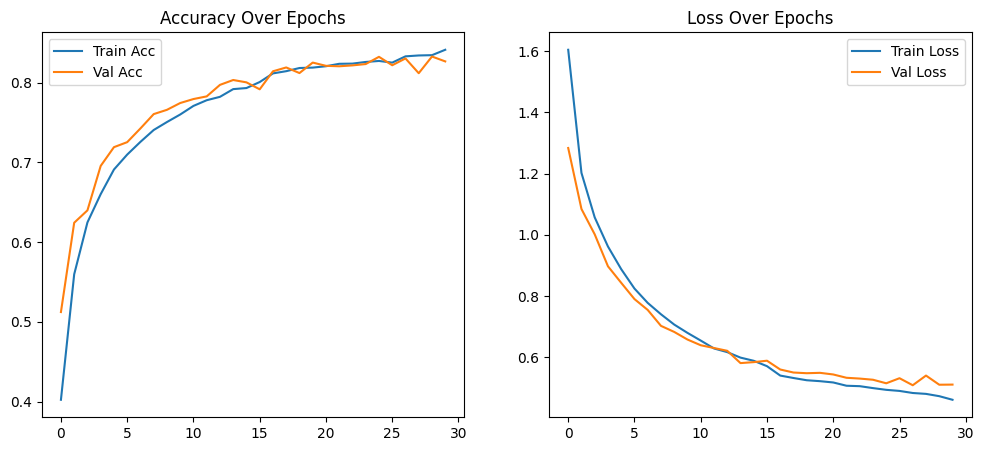

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Train Acc')
plt.plot(epochs, val_acc, label='Val Acc')
plt.title('Accuracy Over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Train Loss')
plt.plot(epochs, val_loss, label='Val Loss')
plt.title('Loss Over Epochs')
plt.legend()
plt.show()

WIll try to see the model performace with more number of epochs as the model is learning


In [ ]:
from tensorflow.keras.models import load_model

model = load_model("best_model.keras")

In [ ]:
learning_rate = 0.0001
optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
callbacks = [
    EarlyStopping(patience=4, restore_best_weights=True, verbose=1),
    ModelCheckpoint("best_model_finetuned.keras", save_best_only=True, verbose=1)
]

In [ ]:
history_finetune = model.fit(
    train_ds,
    validation_data=val_ds,
    initial_epoch=30,   # resume from here
    epochs=50,          # train up to this epoch
    callbacks=callbacks,
    verbose=1
)

Epoch 31/50
338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step - accuracy: 0.8259 - loss: 0.5034
Epoch 31: val_loss improved from inf to 0.51266, saving model to best_model_finetuned.keras
338/338 ━━━━━━━━━━━━━━━━━━━━ 131s 383ms/step - accuracy: 0.8259 - loss: 0.5034 - val_accuracy: 0.8326 - val_loss: 0.5127
Epoch 32/50
338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step - accuracy: 0.8309 - loss: 0.4802
Epoch 32: val_loss improved from 0.51266 to 0.50445, saving model to best_model_finetuned.keras
338/338 ━━━━━━━━━━━━━━━━━━━━ 125s 371ms/step - accuracy: 0.8309 - loss: 0.4802 - val_accuracy: 0.8348 - val_loss: 0.5044
Epoch 33/50
338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step - accuracy: 0.8353 - loss: 0.4704
Epoch 33: val_loss did not improve from 0.50445
338/338 ━━━━━━━━━━━━━━━━━━━━ 141s 370ms/step - accuracy: 0.8353 - loss: 0.4704 - val_accuracy: 0.8230 - val_loss: 0.5206
Epoch 34/50
338/338 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step - accuracy: 0.8389 - loss: 0.4631
Epoch 34: val_loss improved from 0.50445 to 0

Load the Best Model

In [ ]:
model = load_model("best_model_finetuned.keras")

Evaluate on Validation/Test Data

In [ ]:
val_loss, val_acc = model.evaluate(val_ds)
print(f"Final Validation Accuracy: {val_acc:.4f}")

85/85 ━━━━━━━━━━━━━━━━━━━━ 7s 80ms/step - accuracy: 0.8500 - loss: 0.4696
Final Validation Accuracy: 0.8409


Confusion Matrix and Classification Report

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
2/2 ━━━

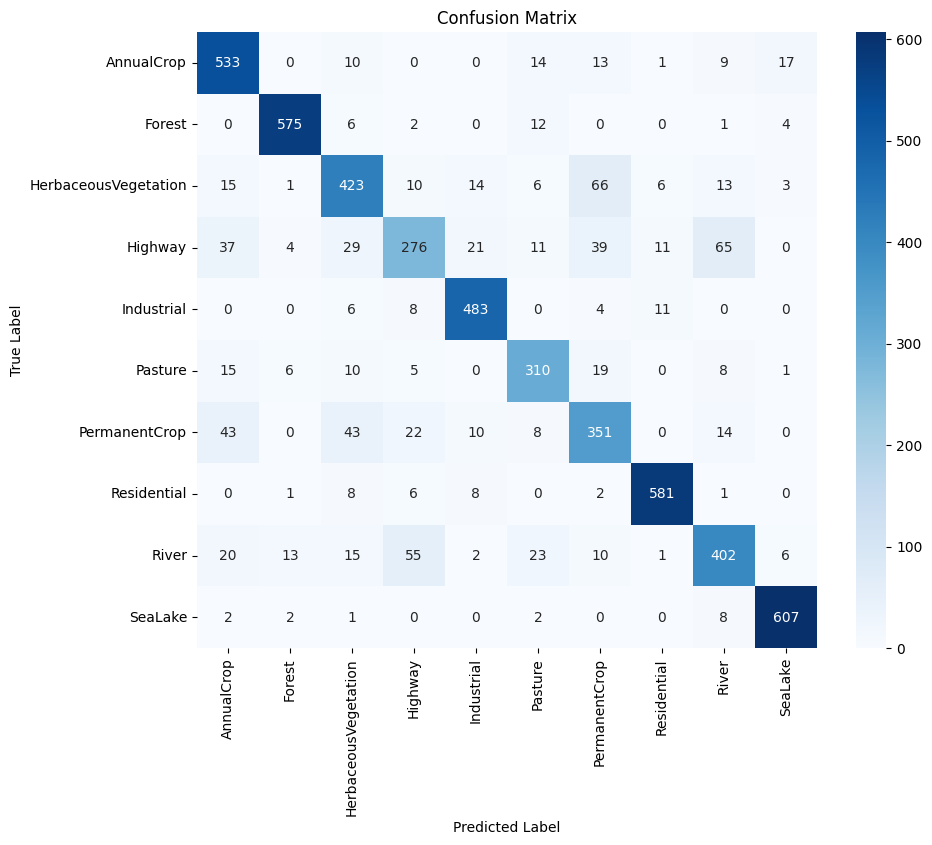

Classification Report:
                      precision    recall  f1-score   support

          AnnualCrop       0.80      0.89      0.84       597
              Forest       0.96      0.96      0.96       600
HerbaceousVegetation       0.77      0.76      0.76       557
             Highway       0.72      0.56      0.63       493
          Industrial       0.90      0.94      0.92       512
             Pasture       0.80      0.83      0.82       374
       PermanentCrop       0.70      0.71      0.71       491
         Residential       0.95      0.96      0.95       607
               River       0.77      0.73      0.75       547
             SeaLake       0.95      0.98      0.96       622

            accuracy                           0.84      5400
           macro avg       0.83      0.83      0.83      5400
        weighted avg       0.84      0.84      0.84      5400



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Generate predictions
y_true, y_pred = [], []

for images, labels in val_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

Predict Uploaded Images Using Your Model

In [ ]:
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Example: Choose any image from the EuroSAT dataset
# img_path = "EuroSAT_RGB/Forest/Forest_10.jpg"
img_path = "EuroSAT_RGB/AnnualCrop/AnnualCrop_1000.jpg"

In [ ]:
def load_and_preprocess_image(img_path, target_size=(64, 64)):
    img = Image.open(img_path).convert("RGB")
    img = img.resize(target_size)
    img_array = np.array(img) / 255.0  # Normalize
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    return img_array, img

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
Image path: EuroSAT_RGB/AnnualCrop/AnnualCrop_1000.jpg
Predicted Class: AnnualCrop
Confidence: 1.00


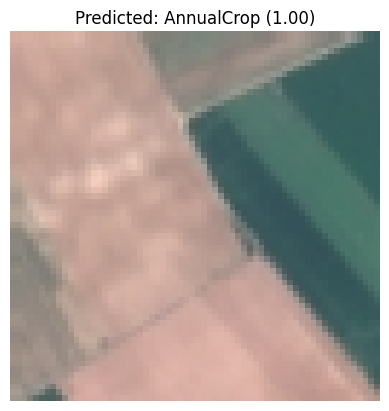

In [ ]:
img_array, raw_img = load_and_preprocess_image(img_path)
prediction = model.predict(img_array)
predicted_class = class_names[np.argmax(prediction)]
confidence = np.max(prediction)

# Display
print(f"Image path: {img_path}")
print(f"Predicted Class: {predicted_class}")
print(f"Confidence: {confidence:.2f}")

plt.imshow(raw_img)
plt.title(f"Predicted: {predicted_class} ({confidence:.2f})")
plt.axis("off")
plt.show()